# Network Observability
This example creates a simple feedforward PyTorch model with a linear output functions and randomized weights (not trained for a specific purpose). Then, it uses random sets of inputs to construct an observability matrix given measurements from specified neurons (output or hidden layer neurons). Then the Fisher information + inverse is computed and used to assess the observability of each network weight/bias. The network is visualized such that the measured neurons are indicated and the connections are colored by their observability level.

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchsummary import summary

from pybounds import EmpiricalObservabilityMatrix, FisherObservability
from network_simulator import NetworkSimulator, FCNNVisualizer

C:\Users\bcell\anaconda3\envs\torch-main\lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
C:\Users\bcell\anaconda3\envs\torch-main\lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Test pytorch GPU

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2080 Ti


# Define network

In [3]:
# Define a simple feedforward neural network with 8 inputs and 2 outputs
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Three layers with no bias terms
        self.fc1 = nn.Linear(8, 6, bias=False)
        self.fc2 = nn.Linear(6, 4, bias=False)
        self.fc3 = nn.Linear(4, 2, bias=False)

    def forward(self, x):
        # ReLu activations for input & hidden layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Create the neural network
model = SimpleNN().to(device)

In [5]:
# Get a summary of the model
summary(model, (8,))  # Input size: 8 features

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 6]              48
            Linear-2                    [-1, 4]              24
            Linear-3                    [-1, 2]               8
Total params: 80
Trainable params: 80
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Define simulator object for observability analysis

In [6]:
simulator = NetworkSimulator(model, device=device, output_mode='full')

In [7]:
layer_sizes = simulator.layer_sizes
print('layer sizes:', layer_sizes)

layer sizes: (8, 6, 4, 2)


## Set network weights

In [8]:
# Randomly set weights for this example
np.random.seed(seed=5)
network_weights = np.random.normal(loc=0.0, scale=1.0, size=simulator.initial_weights_numpy.shape)
simulator.set_weights(network_weights)

## Set inputs to use

In [9]:
n_sample = 100  # number of input sequences to use, should be at least > then number of network parameters for observability
u = torch.rand((n_sample, simulator.param_shapes[0][1])).to(device)
u_cpu = u.cpu().data.numpy()

## Set what neurons to measure

In [10]:
simulator.output_mask[0:-3] = 0  # set all but the last 3 neurons off (only measure the last 3 neurons)
simulator.output_mask

array([False, False, False, False, False, False, False, False, False,
        True,  True,  True])


# Simulate the network with given weights & inputs

In [11]:
y = simulator.simulate(x0=network_weights, u=u_cpu)
print('Neurons measured:', simulator.measurement_names)

Neurons measured: ['fc2_neuron_4', 'fc3_neuron_1', 'fc3_neuron_2']


In [12]:
print('Network measurements over time:')
simulator.y

Network measurements over time:


,fc2_neuron_4,fc3_neuron_1,fc3_neuron_2
0,-4.463780,0.844578,0.409426
1,-1.097222,-0.900034,-0.425995
2,2.128673,-4.077174,-1.040345
3,1.049354,-2.566560,-0.776327
4,2.158935,-4.634249,-1.291370
...,...,...,...
95,-0.488263,-1.099574,-0.528682
96,-0.388473,-1.779532,-0.867574
97,1.565367,-3.149345,-0.861613
98,-0.306506,-0.740399,-0.361667


# Construct observability matrix

In [13]:
EOM = EmpiricalObservabilityMatrix(simulator, x0=network_weights, u=u_cpu, eps=1e-5, parallel=False)

In [14]:
O = EOM.O_df
O

fc1_weight_0  fc1_weight_1  fc1_weight_2  \
sensor       time_step                                             
fc2_neuron_4 0              0.333786      1.096725      0.238419   
fc3_neuron_1 0             -0.116229     -0.324845     -0.080466   
fc3_neuron_2 0             -0.055134     -0.159442     -0.038743   
fc2_neuron_4 1              0.143051      1.174212      0.482798   
fc3_neuron_1 1              0.029802      0.244379      0.101328   
...                              ...           ...           ...   
             98             0.327826      0.393391      0.414252   
fc3_neuron_2 98             0.163913      0.196695      0.207126   
fc2_neuron_4 99             0.250340      0.846386      0.756979   
fc3_neuron_1 99            -0.178814     -0.643730     -0.584126   
fc3_neuron_2 99             0.020862      0.065565      0.053644   

                        fc1_weight_3  fc1_weight_4  fc1_weight_5  \
sensor       time_step                                             
fc2_neuron_4 0              0.166893      0.119209      0.143051   
fc3_neuron_1 0             -0.062585     -0.032783     -0.044703   
fc3_neuron_2 0             -0.031292     -0.014901     -0.023842   
fc2_neuron_4 1              0.810623      0.077486      0.530481   
fc3_neuron_1 1              0.166893      0.020862      0.113249   
...                              ...           ...           ...   
             98             0.724196      0.387430      0.181794   
fc3_neuron_2 98             0.363588      0.193715      0.089407   
fc2_neuron_4 99             0.375509      0.470877      0.858307   
fc3_neuron_1 99            -0.286102     -0.357628     -0.655651   
fc3_neuron_2 99             0.026822      0.035763      0.062585   

                        fc1_weight_6  fc1_weight_7  fc1_weight_8  \
sensor       time_step                                             
fc2_neuron_4 0              0.143051      0.524521           0.0   
fc3_neuron_1 0             -0.038743     -0.163913           0.0   
fc3_neuron_2 0             -0.020862     -0.074506           0.0   
fc2_neuron_4 1              0.590086      0.256300           0.0   
fc3_neuron_1 1              0.122190      0.050664           0.0   
...                              ...           ...           ...   
             98             0.149012      0.482798           0.0   
fc3_neuron_2 98             0.073016      0.241399           0.0   
fc2_neuron_4 99             0.768900      0.989437           0.0   
fc3_neuron_1 99            -0.584126     -0.751019           0.0   
fc3_neuron_2 99             0.056624      0.077486           0.0   

                        fc1_weight_9  ...  fc2_weight_22  fc2_weight_23  \
sensor       time_step                ...                                 
fc2_neuron_4 0                   0.0  ...       0.786781       0.095367   
fc3_neuron_1 0                   0.0  ...       0.000000       0.000000   
fc3_neuron_2 0                   0.0  ...       0.000000       0.000000   
fc2_neuron_4 1                   0.0  ...       0.947714       1.055002   
fc3_neuron_1 1                   0.0  ...       0.000000       0.000000   
...                              ...  ...            ...            ...   
             98                  0.0  ...       0.000000       0.000000   
fc3_neuron_2 98                  0.0  ...       0.000000       0.000000   
fc2_neuron_4 99                  0.0  ...       2.253056       1.958013   
fc3_neuron_1 99                  0.0  ...      -3.147125      -2.741814   
fc3_neuron_2 99                  0.0  ...      -0.548363      -0.476837   

                        fc3_weight_0  fc3_weight_1  fc3_weight_2  \
sensor       time_step                                             
fc2_neuron_4 0              0.000000      0.000000      0.000000   
fc3_neuron_1 0              0.917912      1.922250      0.000000   
fc3_neuron_2 0              0.000000      0.000000      0.000000   
fc2_neuron_4 1              0.000000      0.000000   

# Compute the Fisher information & min. error covariance of each network parameter

In [15]:
FO = FisherObservability(O, R=0.1, lam=1e-8)  # R is the noise level for the measurement of each neuron, lambda is the upper bound on the error variance. See pybounds: https://github.com/vanbreugel-lab/pybounds
F, F_inv, R = FO.get_fisher_information()

In [16]:
MEV = pd.DataFrame(np.diag(F_inv), index=F_inv.columns)
error_variance = MEV.values.squeeze()
MEV

,0
fc1_weight_0,0.231877
fc1_weight_1,0.225914
fc1_weight_2,4.475902
fc1_weight_3,0.196034
fc1_weight_4,0.116995
...,...
fc3_weight_3,0.020390
fc3_weight_4,155294.694101
fc3_weight_5,0.268748
fc3_weight_6,26.057652


# Plot min. error variance of each network weight

In [17]:
vmin = 1e-4
vmax = 1e10
cnorm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap = mpl.colormaps['seismic_r']

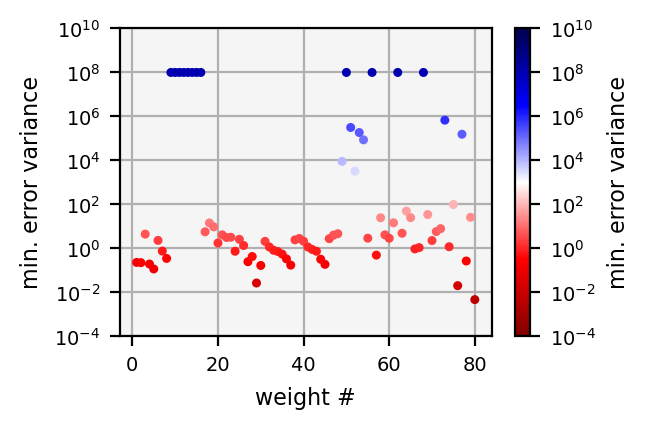

In [18]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=200)
scatter = ax.scatter(np.arange(1, error_variance.shape[0] + 1), error_variance, c=error_variance,
                     s=5, norm=cnorm, cmap=cmap, zorder=2)
ax.set_yscale('log')
ax.set_ylim(vmin, vmax)
ax.set_xlabel('weight #', fontsize=8)
ax.set_ylabel('min. error variance', fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.grid(zorder=0)
ax.set_facecolor('whitesmoke')

cbar = plt.colorbar(scatter)
cbar.set_label('min. error variance', fontsize=8)
cbar.ax.tick_params(labelsize=7)

# Visualize network 

In [19]:
# Set connection colors equal to the error variance associated with each weight
connection_colors = error_variance.copy()

In [20]:
# Set neuron colors
input_color = 0.0 * np.ones(simulator.layer_sizes[0]) # make mask of all 0's for input layer
hidden_output_color = 0.5*simulator.output_mask.astype(float) + 0.5 # make unmeasured neurons 0.5 & measured 1.0
neuron_colors = np.hstack((input_color, hidden_output_color)) # stack values

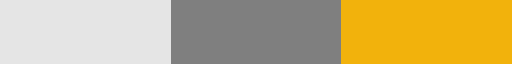

In [21]:
# Set colors of neurons
cmap_neuron = np.array([[0.9, 0.9, 0.9], # input layer neurons
                        [0.5, 0.5, 0.5],  # hidden & output layer unmeasured neurons
                        [0.95, 0.7, 0.05]]) # hidden & output layer measured neurons
cmap_neuron = mpl.colors.ListedColormap(cmap_neuron)
cmap_neuron

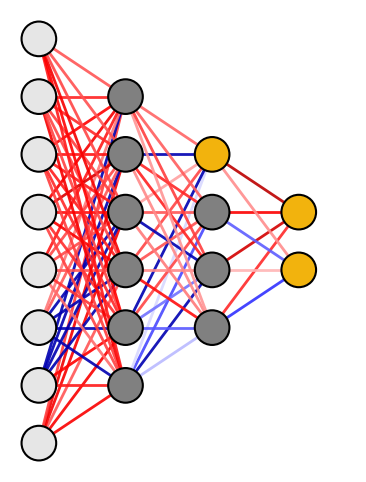

In [22]:
# Create network visualizer & draw
network = FCNNVisualizer(layer_sizes)

# Set colors
network.set_colors(name='connection', values=connection_colors, colormap=cmap, norm=cnorm)
network.set_colors(name='neuron', values=neuron_colors, colormap=cmap_neuron, norm=None)

# Draw
network.draw()

# More info on network visualization

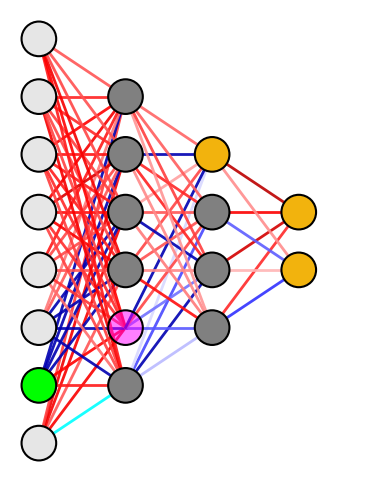

In [28]:
# Can also set colors by changing the properties directly
network.neuron_colors[1] = (0.0, 1.0, 0.0, 1.0)
network.neuron_colors[9] = (1.0, 0.0, 1.0, 0.5)
network.connection_colors[0] = (0.0, 1.0, 1.0, 1.0)
network.draw()